In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from pprint import pprint

In [53]:
# Generate some data that we'll test against

start = 0
stop = 10
samples = 50
noise = 20

def true_value(x):
    return -9.81 * x**2

xs = [random.uniform(start, stop) for _ in range(samples)]
ys = [true_value(x) + random.random() * noise for x in xs]
data = list(zip(xs, ys))

Now we have some data. We have a pretty good sense about what happens visually, but how would we represent that to a computer?

[(1.3779350098670928, -5.514967593916751),
 (8.349640563538353, -681.0804447892762),
 (6.228210686197599, -378.0580276693719),
 (5.60565303769687, -288.66284914077517),
 (9.586144677421927, -896.3037186333096),
 (7.78617681602431, -583.9414186304515),
 (7.648352329903554, -564.0877777709838),
 (8.239764002769137, -657.1872960064859),
 (7.661129386411907, -573.3104128447397),
 (8.77605792470913, -736.304239020087),
 (8.455950153210537, -688.3662964095519),
 (5.554059318334293, -283.0641902315052),
 (9.890593500870466, -948.8739361582367),
 (7.155361709244304, -497.010372151165),
 (4.850848674805376, -226.58094403367897),
 (6.277765793247494, -368.8754633295687),
 (0.8279985470256324, -2.611782604326204),
 (7.714440080674283, -573.0011974244934),
 (3.2479199855766216, -91.21801747853698),
 (9.94487186169997, -961.4117229294189),
 (4.870148572976789, -219.83380922972208),
 (1.2110473671063748, -10.448384803204583),
 (5.9051368528780115, -326.1301404809383),
 (4.536756274041386, -189.36506

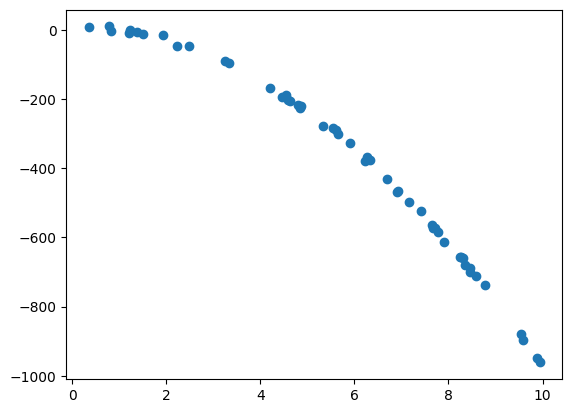

In [54]:
pprint(data) 
plt.scatter(xs, ys)
plt.show()

So to begin we want to define a model. A model is going to do _something_ under the hood, and when we give it an input we expect to get an output. We'll start by defining a drop dead simple model that just returns the input back to us.

In [26]:
def model(x):
    return x

Ok! Now we have a model. So we need to determine how "good" the model is at fitting our data. An easy way to check this is to say "if I give the model `x`, how far away is that from `data[x]`. We need to be a bit careful: we can't just say `data[x] - model(x)` because our model could be off in two very different directions and they would cancel out. So instead we'll square the values. This gives us a function for "loss". To assess the overall strength of the model, we'll calculate the average loss over our entire data set.

In [103]:
def calculate_loss(model):
    return sum((y - model(x)) ** 2 for x,y in data)

l1 = (ys[0] - model(xs[0])) ** 2
l2 = (ys[1] - model(xs[1])) ** 2
loss = calculate_loss(model)
print(f"{l1=}")
print(f"{l2=}")
print(f"{loss=}")


l1=30.414867561951915
l2=463870.57227435824
loss=11219106.982504597


Not great. That is a pretty big loss. But obviously, we chose a model that doesn't really line up with our data. So, for our next step, we're going to assume we know the _form_ of the data (in this case it's a quadratic). We'll talk in the future about what we can do when we don't know the form of our data. So, for a simple quadratic we have something new: a model paramater. This is a knob that we can adjust to see how well our model is performing. Let's write our new model and play with the parameter a bit.

In [104]:
class ParameterizedModel():
    def __init__(self, parameter):
        self.parameter = parameter
    
    def __call__(self, x):
        return self.parameter * x ** 2
    
model1 = ParameterizedModel(0)
model2 = ParameterizedModel(-10)

loss1 = calculate_loss(model1)
loss2 = calculate_loss(model2)
print(f"{loss1=:,.2f}, {loss2=:,.2f}")

loss1=11,219,106.98, loss2=18,298.55


Ok, now we're getting somewhere! We can say that model2 is a "better" model (at least given the loss function we've defined). Now the question becomes: what can we do to get the "best" model? What would give us the lowest loss? Obviously we can't just guess and check ourselves, but we can have a computer do that.

In [110]:
def simple_optimize(model, delta=0.1, iterations=1000):
    for i in range(iterations):
        # Calculate the loss if we move up by delta.
        model_candidate1 = ParameterizedModel(model.parameter + delta)
        loss1 = calculate_loss(model_candidate1)
        # Calculate the loss if we move down by delta.
        model_candidate2 = ParameterizedModel(model.parameter - delta)
        loss2 = calculate_loss(model_candidate2)
        # Calculate the current loss.
        current_loss = calculate_loss(model)
        
        if loss1 < current_loss:
            model = model_candidate1
        elif loss2 < current_loss:
            model = model_candidate2
        else:
            # We've optimized as much as we can.
            print(f"Breaking after {i} iterations")
            break
    return model

optimized = simple_optimize(ParameterizedModel(0))
loss = calculate_loss(optimized)
print(f"{loss=:.2f}, {optimized.parameter=}")

Breaking after 96 iterations
loss=3750.59, optimized.parameter=-9.599999999999982


Now, this is great! We've reduced our loss significantly and we've got a model which can give us some predictive power. But it's not very stable. We have a very high dependence on our starting position; if we start far away it takes much longer to get there. Additionally, we are limited by our delta. Ok, so what could we do with this? Well there's a broad idea that when we don't know much (at the start) we should move much further. And as we get closer and closer, we can make smaller and smaller updates.

To start with this idea, let's begin by plotting loss over the range of parameters.

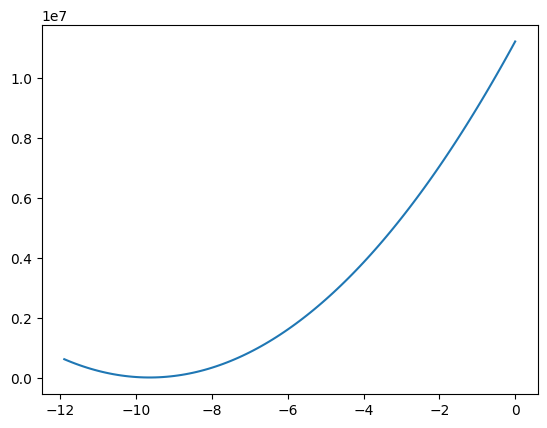

In [106]:
loss_xs = [-x * 0.1 for x in range(0, 120)]
loss_ys = []
for x in loss_xs:
    model = ParameterizedModel(x)
    loss = calculate_loss(model)
    loss_ys.append(loss)
plt.plot(loss_xs, loss_ys)
plt.show()

So how do we determine how far we should jump given our current loss? To do this, we want to measure the **derivative** of loss. Now, in this specific case, we could calculate this analytically: `dLoss/dp = d/dp(\sum ((p * x ^ 2) - y)^2) = 2 p x^4 - 2 x^2 y` (thanks WolframAlpha, but should be all relatively straightforward calculus)

In [107]:
def analytic_derivative(p):
    return sum(2 * p * x**4 - 2 * x **2 * y for (x,y) in data)

Now, we could use this analytical derivative in our optimization. At each step we move a little bit in the _negative_ direction of the derivative (negative, since we want to minimize loss).

In [111]:
def simple_optimize(model, learning_rate=1e-7, iterations=1000, min_delta=1e-8):
    for i in range(iterations):
        derivative = analytic_derivative(model.parameter)
        delta = learning_rate * -derivative 
        if abs(delta) < min_delta:
            print(f"Breaking after {i} iterations")
            break
        model = ParameterizedModel(delta + model.parameter)
    return model

optimized = simple_optimize(ParameterizedModel(-10))
loss = calculate_loss(optimized)
print(f"{loss=:.2f}, {optimized.parameter=:.3f}")

Breaking after 560 iterations
loss=3460.86, optimized.parameter=-9.649


Now, analytical derivatives are great, but really a pain to calculate by hand. How can we have the computer calculate the derivative for us? To accomplish this, we'll use a process called backpropegation. This relies on the fact that the loss function is a relatively straightforward series of function applications and we can use the chain rule to compute the derivative directly.